In [1]:
import csv
import gensim
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
import os
import pandas as pd
import re
import seaborn as sns
import sys

from collections import OrderedDict
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS
from gensim.utils import simple_preprocess
from multiprocessing import Pool


In [2]:
STOPWORDS = set(STOPWORDS).union(set(['patient', 'patients', 'study', 'disease',
                                      'treatment', 'randomized', 'statistical', 'analysis'
                                      'group', 'trial', 'clinical', 'controlled', 'safety',
                                      'associated', 'risk', 'intervention', 'care', 'health',
                                      'therapy', 'participants', 'method', 'monitor', 'studies',
                                      'cohorts', 'percent', 'prospective', 'efficacy', 'days', 'months',
                                      'evaluate', 'subjects', 'data', 'outcomes', 'research',
                                      'function', 'effects', 'investigators', 'use',
                                      'population', 'compared', 'quality', 'results', 'improve',
                                      'term', 'group', 'weeks', 'week', 'groups', 'test', 'control', 'time', 'period'
                                      'placebo', 'stimulation', 'symptoms', 'mortality', 'failure',
                                      'non', 'interventional', 'observational', 'assess', 'relative', 'positive',
                                      'develop', 'signs', 'enrolled', 'randomly', 'assigned', 'ratio', 'stratified',
                                      'multicenter', 'open', 'phase', 'stage', 'iiib', 'eligible', ]))


In [3]:
df = pd.read_csv('../frontend_dataset_final.csv')

In [4]:
# def transform_instance(row):
#     cur_row = []
#     label = "__label__" + index_to_label[row[0]]  #Prefix the index-ed label with __label__
#     cur_row.append(label)
#     cur_row.extend(nltk.word_tokenize(row[3].lower()))
#     cur_row.extend(nltk.word_tokenize(row[5].lower()))
#     cur_row.extend(nltk.word_tokenize(row[7].lower()))
#     cur_row.extend(nltk.word_tokenize(row[10].lower()))
#     cur_row.extend(nltk.word_tokenize(row[11].lower()))
#     return cur_row

In [5]:
# def preprocess(input_file, output_file, keep=1):
#     all_rows = []
#     with open(input_file, 'r') as csvinfile:
#         csv_reader = csv.reader(csvinfile, delimiter=',')
#         for row in csv_reader:
#             all_rows.append(row)
#     shuffle(all_rows)
#     all_rows = all_rows[:int(keep*len(all_rows))]
#     pool = Pool(processes=multiprocessing.cpu_count())
#     transformed_rows = pool.map(transform_instance, all_rows)
#     pool.close() 
#     pool.join()
    
#     with open(output_file, 'w') as csvoutfile:
#         csv_writer = csv.writer(csvoutfile, delimiter=' ', lineterminator='\n')
#         csv_writer.writerows(transformed_rows)

In [6]:
df = df.drop(columns='Unnamed: 0')
df.head()

,agency,brief_title,brief_summary,city,condition,country,detailed_description,eligibility,gender,keyword,mesh_term,official_title,overall_status,phase,state,url
0,Fraunhofer Institute for Molecular Biology and...,PREVALENCE OF Anti-CCP POSITIVITY AND SUBCLINI...,"Non-interventional, prospective, observational...",Frankfurt am Main,Rheumatoid Arthritis,Germany,Studies of early arthritis cohorts have shown ...,population without pre-classified RA but new o...,All,Anti-CCP,Arthritis,PREVALENCE OF ANTI-CYCLIC CITRULLINATED PEPTID...,Recruiting,Missing,Hessia,https://clinicaltrials.gov/show/NCT03267147
1,University of Washington,Aldesleukin and Pembrolizumab in Treating Pati...,This phase I trial studies the side effects an...,Seattle,Clear Cell Renal Cell Carcinoma,United States,PRIMARY OBJECTIVES: I. To evaluate the safety ...,Inclusion Criteria: - Be willing and able to ...,All,Missing,Carcinoma,A Phase I Trial of Interleukin-2 (Aldesleukin)...,Recruiting,Phase 1,Washington,https://clinicaltrials.gov/show/NCT03260504
2,"CSPC ZhongQi Pharmaceutical Technology Co., Ltd.",Nab-Paclitaxel Versus Paclitaxel Plus Carbopla...,"This is a randomized, multicenter, open, contr...",Missing,Non-small Cell Lung Cancer,Missing,Subjects will receive one of two treatment reg...,Inclusion Criteria: - Accepted the purpose of...,All,Missing,Lung Neoplasms,"The Randomized,Open, Multicenter Phase III Stu...",Not yet recruiting,Phase 3,Missing,https://clinicaltrials.gov/show/NCT03262948
3,Fraunhofer Institute for Molecular Biology and...,PREVALENCE OF Anti-CCP POSITIVITY AND SUBCLINI...,"Non-interventional, prospective, observational...",Frankfurt am Main,Rheumatoid Arthritis,Germany,Studies of early arthritis cohorts have shown ...,population without pre-classified RA but new o...,All,Anti-CCP,Arthritis,PREVALENCE OF ANTI-CYCLIC CITRULLINATED PEPTID...,Recruiting,Missing,Hessia,https://clinicaltrials.gov/show/NCT03267147
4,Chang Gung Memorial Hospital,Analgesic Effect of Low Level Laser for Proced...,Neonates undergo several painful procedures an...,Kaohsiung,Procedural Pain,Taiwan,"This open-label, randomized controlled trial i...",Inclusion Criteria: - healthy fullterm neonat...,All,neonates,"Pain, Procedural",Analgesic Effect of Low Level Laser for Proced...,Recruiting,Missing,Missing,https://clinicaltrials.gov/show/NCT03268148


In [7]:
df['search_terms'] = (df['mesh_term'].str.lower()
                      + ' ' + df['condition'].str.lower() 
                      + ' ' + df['keyword'].str.lower()
                      + ' ' + df['brief_summary'].str.lower()
                      + ' ' + df['official_title'].str.lower()
                      + ' ' + df['detailed_description'].str.lower()
                      + ' ' + df['eligibility'].str.lower()
                      )

In [8]:
df['search_terms'].iloc[0]

'arthritis rheumatoid arthritis anti-ccp non-interventional, prospective, observational study to assess the relative risk of anti-ccp positive patients to develop (subclinical) signs of inflammation in accordance with early rheumatoid arthritis (ra) in a population without pre-classified ra but new1 onset of non-specific musculoskeletal (msk) symptoms in general practices in germany and subsequent 36 months follow-up by rheumatologists prevalence of anti-cyclic citrullinated peptide (anti-ccp) positivity and subclinical signs of inflammation in patients with new onset of non-specific musculoskeletal symptoms possibly related to early rheumatoid arthritis in general practices in germany studies of early arthritis cohorts have shown that a large number of early arthritis patients cannot be accurately diagnosed at their first visit, and hence are often referred as undifferentiated arthritis patients. if patients are found to be anti-ccp(+) when referred to the clinician, however, more tha

In [9]:
def set_o_strings(strings):
    new = OrderedDict()
    for string in strings.split():
        new[string] = ''
    return u" ".join(new.keys())

In [10]:
def replace_missing(string):
    new = re.sub('missing', '', string)
    new = re.sub('-', ' ', new)
    new = re.sub('\(\S*\)', '', new)
    return u"{}".format(new)

In [11]:
search_terms = df['search_terms'].apply(replace_missing).values
# search_terms = df['search_terms'].apply(set_o_strings).values
len(search_terms)

22471

In [12]:
test_terms = search_terms.copy()[-2471:]
search_terms = search_terms[:20000]

In [13]:
len(search_terms), len(test_terms)

(20000, 2471)

In [14]:
test_terms[1]

'urinary bladder neoplasms muscle invasive bladder cancer muscle invasive bladder cancer muscle invasive  and/or metastatic bladder cancer is associated with poor prognosis and no target therapies for this pathology are currently validated. by 40 gene expression signature realized on frozen samples, we have previously identified an aggressive sub class of mibc, called basal. this sub class (20 percent of mibc) showed strong egfr dependence in vitro and in vivo (rebouissou et al. science translational medicine 2014). this observation suggests a possible response to egfr targeted therapy in patients of this subgroup. our aim is to establish a standard diagnostic tool to differentiate the basal subtype of bladder cancer and evaluate the effect of anti egfr therapy, by analyzing previous clinical trial  and preclinical models, which compare the classical chemotherapy to anti egfr associated chemotherapy. identification and treatments of basal like bladder cancer (study on human tumor sampl

In [15]:
search_terms[1]

'carcinoma clear cell renal cell carcinoma  this phase i trial studies the side effects and best dose of aldesleukin when given together with pembrolizumab in treating patients with kidney cancer that has spread to other parts of the body. aldesleukin may stimulate white blood cells to kill kidney cancer cells. monoclonal antibodies, such as pembrolizumab, may interfere with the ability of tumor cells to grow and spread. giving aldesleukin and pembrolizumab may work better in treating patients with kidney cancer. a phase i trial of interleukin 2  and pembrolizumab combination therapy for patients with advanced renal cell carcinoma primary objectives: i. to evaluate the safety and tolerability of aldesleukin (il 2) combined with pembrolizumab (mk 3475) in patients with metastatic clear cell renal cell carcinoma . secondary objectives: i. to assess preliminary antitumor activity of pembrolizumab in combination with il 2. exploratory objectives: i. to investigate the association of pd l1 

In [16]:
def tokenize(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]

In [17]:
pool = Pool(processes=multiprocessing.cpu_count())

keyword_tokens = pool.map(tokenize, search_terms)

In [18]:
keyword_tokens[1]

['carcinoma',
 'clear',
 'cell',
 'renal',
 'cell',
 'carcinoma',
 'best',
 'dose',
 'aldesleukin',
 'given',
 'pembrolizumab',
 'treating',
 'kidney',
 'cancer',
 'spread',
 'parts',
 'body',
 'aldesleukin',
 'stimulate',
 'white',
 'blood',
 'cells',
 'kill',
 'kidney',
 'cancer',
 'cells',
 'monoclonal',
 'antibodies',
 'pembrolizumab',
 'interfere',
 'ability',
 'tumor',
 'cells',
 'grow',
 'spread',
 'giving',
 'aldesleukin',
 'pembrolizumab',
 'work',
 'better',
 'treating',
 'kidney',
 'cancer',
 'interleukin',
 'pembrolizumab',
 'combination',
 'advanced',
 'renal',
 'cell',
 'carcinoma',
 'primary',
 'objectives',
 'tolerability',
 'aldesleukin',
 'il',
 'combined',
 'pembrolizumab',
 'mk',
 'metastatic',
 'clear',
 'cell',
 'renal',
 'cell',
 'carcinoma',
 'secondary',
 'objectives',
 'preliminary',
 'antitumor',
 'activity',
 'pembrolizumab',
 'combination',
 'il',
 'exploratory',
 'objectives',
 'investigate',
 'association',
 'pd',
 'protein',
 'expression',
 'pretreatment

In [19]:
id2word = corpora.Dictionary(keyword_tokens)

In [20]:
len(id2word.keys())

69836

In [21]:
id2word.filter_extremes(no_below=10, no_above=0.75)
len(id2word.keys())

16427

In [22]:
corpus = [id2word.doc2bow(text) for text in keyword_tokens]

In [23]:
def compute_coherence_values(dictionary, corpus, series, limit, start=2, step=3, passes=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    series: Tokenized list used to create corpus
    start: Int - Start with this many topics
    step: Int - Number of topics from next step to caluculate
    limit : Max num of topics
    passes: the number of times the entire lda model & coherence values are calculated

    Returns:
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    
    
    for iter_ in range(passes):
        for num_topics in range(start, limit + 1, step):
            model = LdaMulticore(corpus=corpus,
                                 num_topics=num_topics,
                                 id2word=dictionary,
                                 chunksize=10000,
                                 workers=3,
                                 )
    
            coherencemodel = CoherenceModel(model=model,
                                            dictionary=dictionary,
                                            texts=series,
#                                             window_size=50,
                                            coherence='c_uci',
                                            processes=-1,
                                           )
        
            coherence_values.append({'pass': iter_, 
                                     'num_topics': num_topics, 
                                     'coherence_score': coherencemodel.get_coherence()
                                    })

    return coherence_values


/Users/lambda_school_loaner_153/anaconda3/envs/unit4/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


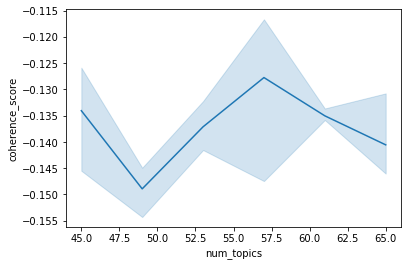

In [24]:
# Can take a long time to run.
coherence_values = compute_coherence_values(dictionary=id2word, 
                                            corpus=corpus,
                                            series=keyword_tokens,
                                            start=45,
                                            step=4,
                                            limit=65, 
                                            passes=3,
                                            )

topic_coherence = pd.DataFrame.from_records(coherence_values)

ax = sns.lineplot(x="num_topics", y="coherence_score", data=topic_coherence)


In [ ]:
# Can take a long time to run.
coherence_values = compute_coherence_values(dictionary=id2word, 
                                            corpus=corpus,
                                            series=keyword_tokens,
                                            start=50,
                                            step=2,
                                            limit=60, 
                                            passes=5,
                                            )

topic_coherence = pd.DataFrame.from_records(coherence_values)

ax = sns.lineplot(x="num_topics", y="coherence_score", data=topic_coherence)


In [37]:
len(topic_coherence['coherence_score'])

30

5 0


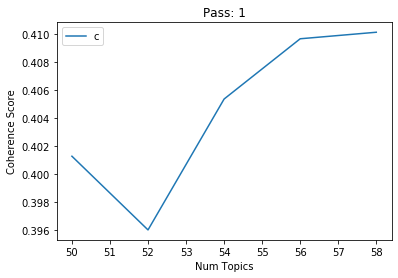

10 5


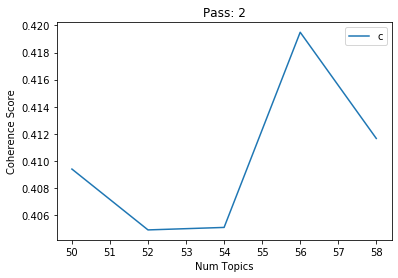

15 10


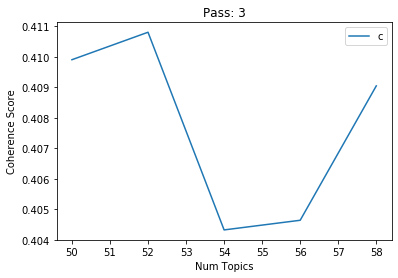

20 15


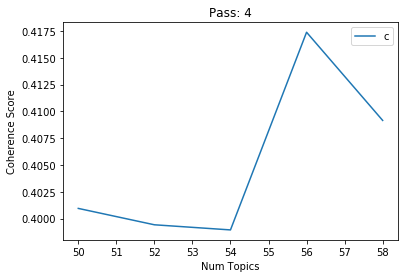

25 20


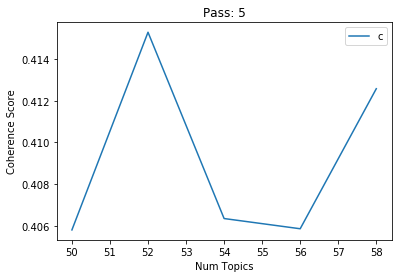

In [40]:
for i in range(5, 30, 5):
    j = i - 5
    print(i, j)
    x = range(50, 60, 2)
    plt.plot(x, topic_coherence['coherence_score'][j:i])
    plt.xlabel('Num Topics')
    plt.ylabel('Coherence Score')
    plt.legend(('coherence_values'))
    plt.title(f'Pass: {i // 5}')
    plt.show()

In [41]:
lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
#                    random_state=42,
                   chunksize=10000,
                   num_topics=56,
                   passes=15,
                   workers=multiprocessing.cpu_count(),
                   )

In [58]:
def get_search_terms(index):
    other_texts = list(map(tokenize, [search_terms[index]]))
    other_corpus = [id2word.doc2bow(text) for text in other_texts]
    unseen_doc = other_corpus[0]
    vector = lda[unseen_doc]  # get topic probability distribution for a document
#     terms = [re.findall(r'"([^"]*)"', topic) for topic in lda.print_topic(vector[np.argmax(vector, axis=0)[1]][0], 20).split(' + ')]
    terms = [topic for topic in lda.print_topic(vector[np.argmax(vector, axis=0)[1]][0], 20).split(' + ')]
    return terms

In [61]:
terms = get_search_terms(14064)

In [62]:
terms

['0.015*"eye"',
 '0.012*"heart"',
 '0.009*"criteria"',
 '0.009*"years"',
 '0.009*"surgery"',
 '0.008*"visual"',
 '0.008*"ocular"',
 '0.008*"glaucoma"',
 '0.007*"af"',
 '0.007*"retinal"',
 '0.006*"atrial"',
 '0.006*"age"',
 '0.006*"corneal"',
 '0.006*"macular"',
 '0.005*"history"',
 '0.005*"fibrillation"',
 '0.005*"inclusion"',
 '0.005*"cataract"',
 '0.005*"ventricular"',
 '0.005*"exclusion"']

In [63]:
search_terms[14064]

'ventricular dysfunction left ventricular dysfunction heart failure according to the results from the literature, it has been shown that levosimendan usage 24 48 hours before lvad implementation can improve short and long term outcome in these patients regarding to the patients without preoperative pretreatment. the aim is to compare short and long term outcome in patients who underwent to lvad implementation and pretreated with levosimendan regarding the patient without pretreatment or with other medications. pretreatment with levosimendan in patients undergoing left ventricular assist device implantation left ventricular assist device  implantation is accepted for treatment of end stage heart failure, in both as the bridging to heart transplantation or as the destination therapy. these patients have highly impaired systolic function which contributes to global heart dysfunction. the main complication is arising of pulmonary vascular pressures and pulmonary vascular resistance  and, c